## Imports

In [1]:
!pip install --upgrade -q accelerate bitsandbytes
!pip install git+https://github.com/huggingface/transformers.git
from transformers import AutoProcessor, LlavaForConditionalGeneration
from transformers import BitsAndBytesConfig
import torch
import requests
from PIL import Image
import matplotlib.pyplot as plt
import os
import pandas as pd
import cv2
import numpy as np

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 342.1/342.1 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 22.6 MB/s eta 0:00:00:00:0100:01
  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-5stsvuwl
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-5stsvuwl
  Resolved https://github.com/huggingface/transformers.git to commit 66f29aaaf55c8fe0c3dbcd24beede2ca4effac56
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.50.0.dev0-py3-none-any.whl size=10875632 sha256=971f73da08c686ed6a4b26afcc697d7ac797ae98bd79e24463455cde6c29c7b5
  Stored in directory: /tmp/pip-ephem-wheel-cache-yrlkbetq/wheels/e7/9c/5b/e1a9c8007c343041e61cc484433d512ea9274272e3fcbe7c16
Successfully built transformers
  Attempting uninstall: transformer

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

## Initialize Model

In [3]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)


model_id = "llava-hf/llava-1.5-7b-hf"

processor = AutoProcessor.from_pretrained(model_id)
model = LlavaForConditionalGeneration.from_pretrained(model_id, quantization_config=quantization_config, device_map="auto")

processor_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/1.45k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.62M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/70.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

## Load Image

In [4]:
def load_cub_dataset(data_dir):
    images = pd.read_csv(os.path.join(data_dir, 'images.txt'), sep=' ', names=['image_id', 'file_path'])
    labels = pd.read_csv(os.path.join(data_dir, 'image_class_labels.txt'), sep=' ', names=['image_id', 'class_id'])
    classes = pd.read_csv(os.path.join(data_dir, 'classes.txt'), sep=' ', names=['class_id', 'class_name'])
    bounding_boxes = pd.read_csv(os.path.join(data_dir, 'bounding_boxes.txt'), sep=' ', names=['image_id', 'x', 'y', 'width', 'height'])
    part_locs = pd.read_csv(os.path.join(data_dir, 'parts/part_locs.txt'), sep=' ', names=['img_id', 'part_id', 'x', 'y', 'visible'])
    # parts = pd.read_csv(os.path.join(data_dir, 'parts/parts.txt'), delimiter =' ', names=['part_id', 'part_name'])
    parts = pd.read_fwf(os.path.join(data_dir, 'parts/parts.txt'), colspecs=[(0, 2), (2, None)], header=None, names=['part_id', 'part_name'])
    return images, labels, classes,  bounding_boxes, parts, part_locs
data_dir = '/kaggle/input/cub2002011/CUB_200_2011'
images_dir = os.path.join(data_dir, 'images')
parts_dir = os.path.join(data_dir, 'parts')

images, labels, classes, bounding_boxes, parts, part_locs = load_cub_dataset(data_dir)

print(images.head())
print(labels.head())
print(classes.head())

print(images.shape)
print(labels.shape)
print(classes.shape)

   image_id                                          file_path
0         1  001.Black_footed_Albatross/Black_Footed_Albatr...
1         2  001.Black_footed_Albatross/Black_Footed_Albatr...
2         3  001.Black_footed_Albatross/Black_Footed_Albatr...
3         4  001.Black_footed_Albatross/Black_Footed_Albatr...
4         5  001.Black_footed_Albatross/Black_Footed_Albatr...
   image_id  class_id
0         1         1
1         2         1
2         3         1
3         4         1
4         5         1
   class_id                  class_name
0         1  001.Black_footed_Albatross
1         2        002.Laysan_Albatross
2         3         003.Sooty_Albatross
3         4       004.Groove_billed_Ani
4         5          005.Crested_Auklet
(11788, 2)
(11788, 2)
(200, 2)


In [5]:
labels.head()

,image_id,class_id
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1


Class: Black footed Albatross
Visible parts: ['back', 'beak', 'breast', 'crown', 'forehead', 'left wing', 'nape', 'right eye', 'right wing', 'tail', 'throat']


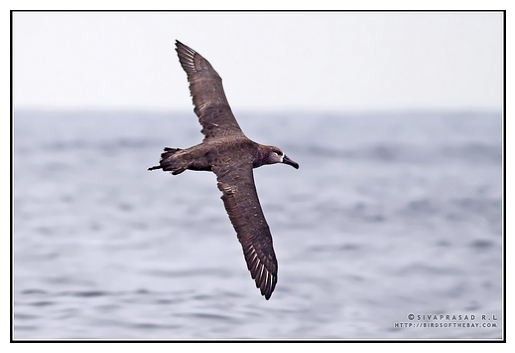

In [6]:
img_id = 2
img_path = os.path.join(images_dir, images[images['image_id'] == img_id]['file_path'].iloc[0])

class_id = labels[labels['image_id'] == img_id]['class_id'].iloc[0]
class_name = " ".join(classes[classes['class_id'] == class_id]['class_name'].iloc[0][4:].split('_'))
print(f'Class: {class_name}')

visible_parts = []
for part in part_locs[part_locs['img_id'] == img_id].itertuples():
    if (part.visible):
        visible_parts.append(parts[parts['part_id'] == part.part_id]['part_name'].iloc[0])
print(f'Visible parts: {visible_parts}')

image = Image.open(img_path)
plt.imshow(image)
plt.axis('off')
plt.show()

# Single Prompt

## Define Prompt

In [7]:
# prompt = 'Please describe the bird in this image, detailing its type'
# prompt = 'Please describe the bird in this image'
# prompt = f'Please describe the bird given that it is a {class_name}'
# prompt = f'Please describe the bird given that it is a {class_name}. The visible parts are: {", ".join(visible_parts)}. Describe the visible parts in the picture.'
prompt = f'Please describe the {visible_parts[7]} of the bird in the picture.'

prompts = [
            # "USER: <image>\nWhat are the things I should be cautious about when I visit this place? What should I bring with me?\nASSISTANT:",
            # "USER: <image>\nPlease describe this image\nASSISTANT:",
            # "USER: <image>\nPlease describe the bird in this image, detailing its type\nASSISTANT:",
            f"USER: <image>\n{prompt}\nASSISTANT:",
]


print(f'Prompt: {prompt}')
inputs = processor(text=prompts, images=[image], padding=True, return_tensors="pt").to("cuda")
for k,v in inputs.items():
    print(k,v.shape)

Prompt: Please describe the right eye of the bird in the picture.
input_ids torch.Size([1, 600])
attention_mask torch.Size([1, 600])
pixel_values torch.Size([1, 3, 336, 336])


## Generate Output

In [ ]:
# output = model.generate(**inputs, max_new_tokens=20)
output = model.generate(**inputs, max_new_tokens=1000)
generated_text = processor.batch_decode(output, skip_special_tokens=True)
# for text in generated_text:
#   print(text.split("ASSISTANT:")[-1])
print(f'Prompt: {prompt}')
print(f'LLava Caption: {generated_text[0].split("ASSISTANT:")[-1]}')
plt.imshow(image)
plt.axis('off')
plt.show()

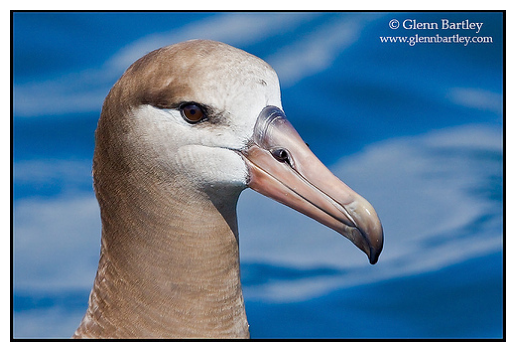

In [7]:
from PIL import ImageEnhance
enhancer = ImageEnhance.Contrast(image)
enhanced_image = enhancer.enhance(1)
plt.imshow(enhanced_image)
plt.axis('off')
plt.show()

# Multiple Prompts

Class: Red winged Blackbird
Visible parts: ['back', 'beak', 'belly', 'breast', 'crown', 'forehead', 'left eye', 'left leg', 'left wing', 'nape', 'right leg', 'tail', 'throat']


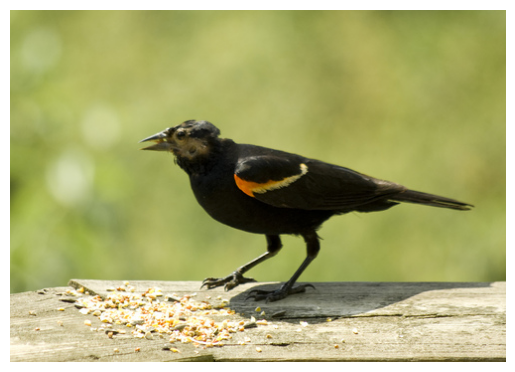

In [24]:
img_id = 500
img_path = os.path.join(images_dir, images[images['image_id'] == img_id]['file_path'].iloc[0])

class_id = labels[labels['image_id'] == img_id]['class_id'].iloc[0]
class_name = " ".join(classes[classes['class_id'] == class_id]['class_name'].iloc[0][4:].split('_'))
print(f'Class: {class_name}')

visible_parts = []
for part in part_locs[part_locs['img_id'] == img_id].itertuples():
    if (part.visible):
        visible_parts.append(parts[parts['part_id'] == part.part_id]['part_name'].iloc[0])
print(f'Visible parts: {visible_parts}')

image = Image.open(img_path)
plt.imshow(image)
plt.axis('off')
plt.show()

In [25]:
prompt = [f'Please describe the {visible_parts[i]} of the bird in the picture.' for i in range(len(visible_parts))]
prompt.append(f'Please describe the environment of the image given that the bird is a {class_name}')


prompts = [
            f"USER: <image>\n{prompt[i]}\nASSISTANT:" for i in range(len(prompt))
]

LLava Caption:  The back of the bird in the picture is black.  The bird in the picture has a long, thin beak.  The bird in the picture has a black belly.  The bird has a red breast, which stands out against its black body.  The bird in the picture has a red crown.  The bird in the picture has a black forehead.  The left eye of the bird in the picture is open.  The left leg of the bird in the picture is black and has a yellow stripe on it.  The left wing of the bird in the picture is black and red.  The bird in the picture has a black nape.  The right leg of the bird in the picture is black and has a yellow stripe on it.  The bird has a long tail, which is a characteristic feature of many bird species. The tail is black and extends from the bird's body, providing additional balance and stability during flight.  The bird in the picture has a bright orange throat.  The image features a Red winged Blackbird standing on a wooden ledge or a wooden fence. The bird is perched on the wooden sur

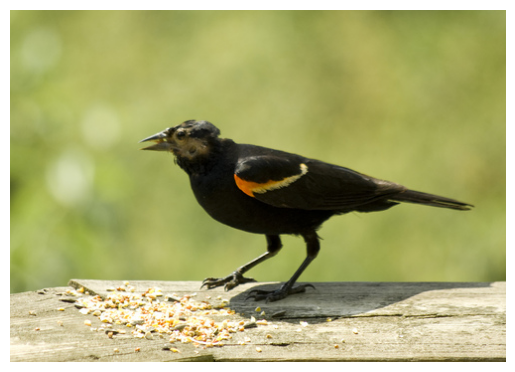

In [26]:
generated_caption = []
for i in range(len(prompts)):
    inputs = processor(text=prompts[i], images=[image], padding=True, return_tensors="pt").to("cuda")
    output = model.generate(**inputs, max_new_tokens=1000)
    generated_text = processor.batch_decode(output, skip_special_tokens=True)
    for text in generated_text:
      generated_caption.append(text.split("ASSISTANT:")[-1])
print(f'LLava Caption: {" ".join(generated_caption)}')
plt.imshow(image)
plt.axis('off')
plt.show()